<a href="https://colab.research.google.com/github/thenambn99/Nemo/blob/master/DIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ImgProc/AI2.zip
!pip install opencv-contrib-python==4.4.0.44

Archive:  /content/drive/MyDrive/ImgProc/AI2.zip
   creating: AI2/
   creating: AI2/test/
   creating: AI2/test/Bacterial leaf blight/
  inflating: AI2/test/Bacterial leaf blight/DSC_0365.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0373.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0379.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0382.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0386.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0389.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0390.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0396.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0401.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0403.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0405.JPG  
  inflating: AI2/test/Bacterial leaf blight/DSC_0702.jpg  
   creating: AI2/test/Brown spot/
  inflating: AI2/test/Brown spot/DSC_0105.jpg  
  inflating: AI2/test/Brown spot/DSC_0108.jpg  
  inflating: AI2/test/Brown

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## 1) Khai báo đường dẫn, các class cần phân loại

In [ ]:
dataDirTrain='/content/AI2/train/' #đường dẫn tệp train
dataDirTest='/content/AI2/test/' #đường dẫn tệp test
classes=['Bacterial leaf blight', 'Leaf smut', 'Brown spot' ] #Khai báo các class cần phân loại

**Định nghĩa hàm load dữ liệu**

In [ ]:
def LoadData(dataDir,new_size=None):
    if not new_size is None:
        img_rows, img_cols = new_size
    classes=[]
    for _,dirs,_ in os.walk(dataDir):
        classes = dirs
        break  
    num_classes=len(classes)    
    X_tr=[]
    Y_tr=[]
    for idx,cl in enumerate(classes):
        for _,_,files in os.walk(dataDir+cl+'/'):               
            l=len(files)
            for f in files:
                img_path=dataDir+cl+'/'+f
                img=cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if not new_size is None:
                    img=cv2.resize(img,(img_rows,img_cols))
                X_tr.append(img)
                Y_tr.append(idx)                       
    return X_tr, Y_tr

**Load ảnh từ tệp dữ liệu và hiển thị 12 ảnh minh hoạ**

Ảnh để train: 580
Label của ảnh train: 580
Ảnh để test: 36
Label của ảnh test: 36


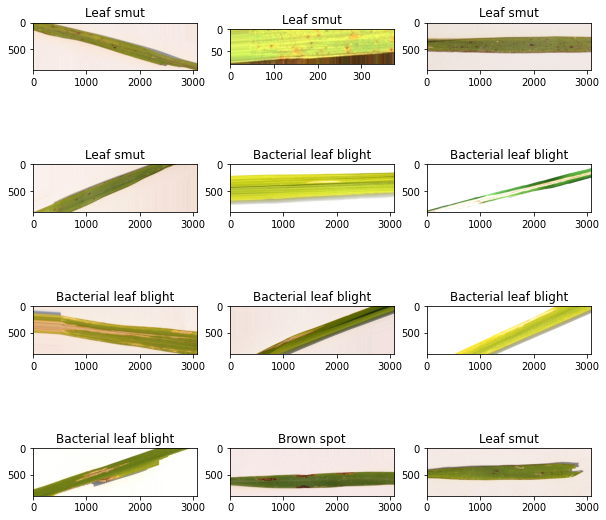

In [ ]:
new_size=(256, 256) #chọn kích thước nhỏ nhất của ảnh trong tệp train
img_train, label_train= LoadData(dataDirTrain,None)
img_test, label_test = LoadData(dataDirTest, None)

print("Ảnh để train: %d" % (len(img_train)))
print("Label của ảnh train: %d" % (len(label_train)))
print("Ảnh để test: %d" % (len(img_test)))
print("Label của ảnh test: %d" % (len(label_test)))

# Hiển thị ngẫu nhiên 12 ảnh mẫu
idxs=np.random.permutation(len(img_train))
plt.figure(figsize = (10,10))
for i in range(12):  # Lấy ngẫu nhiên 12 mẫu trong tập train
    idx=idxs[i]
    plt.subplot(4,3,i+1)
    plt.imshow(img_train[idx])
    plt.title(classes[label_train[idx]])
plt.show()

## 2) Xây dựng đặc trưng

**Xây dựng đặc trưng SIFT (Đưa 1 ảnh đầu vào thì SIFT sẽ xác định được n keypoint. Trên mỗi keypoint sẽ có 1 vector để thể hiện đặc điểm của đặc trưng)**



> Định nghĩa hàm trích xuất đặc trưng SIFT



In [ ]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)         
        image_descriptors.append(des)
    return image_descriptors



> Trích xuất đặc trưng SIFT từ ảnh



In [ ]:
image_descriptors = extract_sift_features(img_train)



> Gọi ngẫu nhiên 20 ảnh đầu và hiện số đặc trưng SIFT có trong từng ảnh đã tính



In [ ]:
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
print((image_descriptors[0].shape))
for i in range(20):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

580
<class 'numpy.ndarray'>
(394, 128)
Image 0 has 394 descriptors
Image 1 has 432 descriptors
Image 2 has 1074 descriptors
Image 3 has 491 descriptors
Image 4 has 772 descriptors
Image 5 has 356 descriptors
Image 6 has 12090 descriptors
Image 7 has 2738 descriptors
Image 8 has 311 descriptors
Image 9 has 302 descriptors
Image 10 has 43 descriptors
Image 11 has 1727 descriptors
Image 12 has 68 descriptors
Image 13 has 384 descriptors
Image 14 has 1357 descriptors
Image 15 has 134 descriptors
Image 16 has 88 descriptors
Image 17 has 327 descriptors
Image 18 has 11469 descriptors
Image 19 has 1936 descriptors




> Tổng số đặc trưng SIFT có trong tệp train



In [ ]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 541659


**Xây dựng từ điển**



> Định nghĩa hàm Kmeans



In [ ]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_
    return bow_dict



> Tạo từ điển



In [ ]:
num_clusters = 200 #Số cụm, có thể thay đổi
if not os.path.isfile('bow_dictionary200.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary200.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary200.pkl', 'rb'))

In [ ]:
print(len(BoW))
print(len(BoW[0]))
print(len(BoW[199]))

200
128
128


**Xây dựng Vector đặc trưng với mô hình túi từ thu được**

In [ ]:
from scipy.spatial.distance import cdist
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)      
        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)            
            argmin = np.argmin(distance, axis=1)            
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

> Tạo tập huấn luyện dựa vào từ điển


In [ ]:
image_descriptors = extract_sift_features(img_train)
X_train = create_features_bow(image_descriptors, BoW, num_clusters)
X_train = np.array(X_train)
Y_train = np.array(label_train)
print('Dữ liệu huấn luyện ')
print("train data: " + str(X_train.shape))
print("train label: " + str(Y_train.shape))

Dữ liệu huấn luyện 
train data: (580, 200)
train label: (580,)




> Tạo tập kiểm thử dựa vào từ điển



In [ ]:
image_descriptors = extract_sift_features(img_test)
X_test = create_features_bow(image_descriptors, BoW, num_clusters)
X_test=np.array(X_test)
Y_test=np.array(label_test)
print('Dữ liệu kiểm thử ')
print("train data: " + str(X_test.shape))
print("train label: " + str(Y_test.shape))

Dữ liệu kiểm thử 
train data: (36, 200)
train label: (36,)


## 4) Huấn luyện mô hình dựa trên SVM Classify

In [ ]:
svm = sklearn.svm.SVC(kernel="linear", C=0.025)
svm.fit(X_train, Y_train)

SVC(C=0.025, kernel='linear')



> Tính độ chính xác trên tập dữ liệu huấn luyện



In [ ]:
svm.score(X_train, Y_train)

0.993103448275862



> Tính độ chính xác trên tập dữ liệu test:



In [ ]:
svm.score(X_test, Y_test)

0.6944444444444444

## 5) Kiểm tra mô hình trên tệp ảnh kiểm thử



> Khai báo nhãn thực tế của tệp kiểm thử



In [ ]:
from keras.utils import np_utils
from imutils import paths
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import os

path_tests1 = list(paths.list_images('/content/AI2/test/Bacterial leaf blight'))
labels_test1 = []

for path_test in path_tests1:
	label1 = path_test.split(os.path.sep)[-2]
	labels_test1.append(label1)
 
path_tests2 = list(paths.list_images('/content/AI2/test/Leaf smut'))
labels_test2 = []

for path_test in path_tests2:
	label2 = path_test.split(os.path.sep)[-2]
	labels_test2.append(label2)
 
path_tests3 = list(paths.list_images('/content/AI2/test/Brown spot'))
labels_test3 = []

for path_test in path_tests3:
	label3 = path_test.split(os.path.sep)[-2]
	labels_test3.append(label3)
labels_test = labels_test1 + labels_test2 + labels_test3



> Dự đoán nhãn của tệp kiểm thử



In [ ]:
import glob
img = None
folder = glob.glob('/content/AI2/test/*/*.*')
preds = []
for file in folder:
  img = cv2.imread(file)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  my_X = [img]
  my_image_descriptors = None
  my_X_features = None
  my_image_descriptors = extract_sift_features(my_X)
  my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
  y_pred = None
  y_pred = svm.predict(my_X_features)
  preds.append(classes[y_pred[0]])

['Leaf smut', 'Bacterial leaf blight', 'Leaf smut', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Leaf smut', 'Brown spot', 'Leaf smut', 'Leaf smut', 'Leaf smut', 'Brown spot', 'Brown spot', 'Leaf smut', 'Leaf smut', 'Leaf smut', 'Leaf smut', 'Leaf smut', 'Brown spot', 'Brown spot', 'Bacterial leaf blight', 'Bacterial leaf blight', 'Brown spot', 'Brown spot', 'Brown spot', 'Leaf smut', 'Leaf smut', 'Brown spot', 'Bacterial leaf blight', 'Bacterial leaf blight']




> Ma trận nhầm lẫn



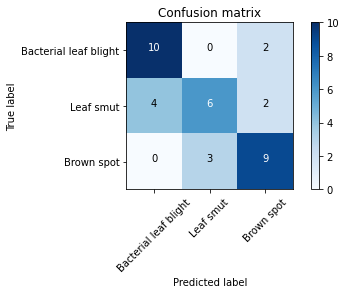

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(labels_test, preds)
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
class_names = ['Bacterial leaf blight', 'Leaf smut', 'Brown spot']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

**Kiểm thử với một số ảnh bên ngoài (tìm trên Google)**

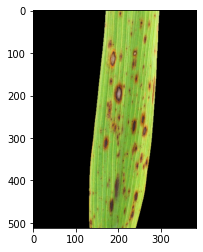

1
(269, 128)
(200,)
[ 7  2  0  0 14  0  3  1  0  0  0  0  8  0  0  3  1  1  1  0  1  0  0  2
  0  0  1  0  1  0  0  0  0  0  1  2  1  4  2  1  1  0  1  0  4  0  1  3
  0  2  1  0  0  1  2  1  1  0  1  0  1  1  0  2  1  2  1  1  0  1  0  1
  0  1  4  2 14  0  6  0  1  8  0  0  2  3  5  0  2  1  0  0  0  2  0  0
  0  0  0  0  0  2  2  0  2  0  0  1  1  1  1  0  0  0  0  3  0  0  5  6
  0  0  0 26  0  0  0  0  0  8 11  0  2  0  0  0  1  0  0  4  1  0  0  0
  0  0  0  0  0  1  0  0  1  0  0  2  1  2  1  0  3  0  0  1  7  0  0  1
  0  1  2  1  0  0  2  0  1  0  1  8  2  0  0  3  0  0  1  0  1  1  0  1
  2  3  1  1  1  1  0  0]
/content/drive/MyDrive/external_images/br5.png
[1]
Loại bệnh: Leaf smut
------------------------------------------


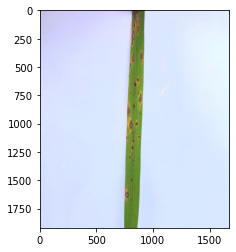

1
(522, 128)
(200,)
[18  0  0  0 10  1  7  3  0  5  1  0  1  3  1  6  1  0  3  1  1  3  1  5
  2  3  0  5  0  1  0  0  0  1  0  4  2  1  1  1  1  0  6  0  0  2  2  4
  0  0  2  8  0  1  7  0  0  4  0  0  1  1  5  5  1  4  6  8  2  3  1  1
  0  1  9  9 23  2  7  0  1  8  0  0  2  3  5  2  0  0  1  3  2  1  8  2
  2  1  2  0  1  2  1  0  0 28  0  3  1  2  2  1  0  2  0  0  2  3  6 10
  0  1  2  3  1  0  0  5  1  7  7  8  7  1  1  4  0  0  1  1 11  3  1  0
  5  0  2  1  0  3  2  0  6  0  0  0  2  4 10  0  0  3  2  7  6  2  1  2
  1  1  0  2  1  0  7  1  7  3  9  4  2  9  7  2  1  0  0  0  1  0  0  1
  0  2  4  2  3  3  0  1]
/content/drive/MyDrive/external_images/bs1.jpg
[1]
Loại bệnh: Leaf smut
------------------------------------------


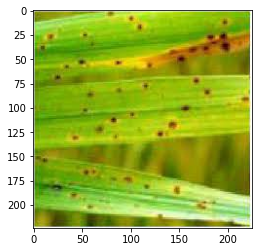

1
(279, 128)
(200,)
[ 2  2  1  0  7  0  2  1  0  8  0  0  0  1  0  0  1  0  0  2  0  0  1  0
  0  0  1  0  0  3  0  0  0  0  2  2  2  0  0  9  0  0  1  0  2  0 10  5
  0  1  1 10  0  0 12  0  0  1  0  1  0  1  2  0  6  1  1  0  4  3  0  1
  1  0  1  5  3  0  1  7  1  2  0  0  3  0  2  2  0  4  0  0  0  0  2  0
  1  2  0  1  0  0  4  2  1  7  0  0  1  0  0  0  0  1  0  0  0  0  1  0
  0  3  0  0  1  1  0  1  0  2  1  1  1  1  0  0  3  0  1  0  5  1  3  6
  3  0  0  1  3  1  8  0  2  1  0  0  1  0 11  0  0  3  0  7  7  0  2  1
  0  2  4  0  0  0  0  5  0  2  1  3  3  4  1  1  1  0  0  0  0  1  1  0
  1  0  0  0  2  0  0  0]
/content/drive/MyDrive/external_images/lsbr1.jpg
[2]
Loại bệnh: Brown spot
------------------------------------------


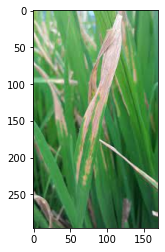

1
(377, 128)
(200,)
[ 3  4  0  0  0  0  2  2  2  1  2  1  1  0  0  2  1  1  0  2  1  0  1  3
  0  5  9  0  1  2  0  0  1  3  3  0  1  0  0  0  4  1  0  0  0  1  2  6
  3  1  0  0  2  1  0  0  1  3  2 12  5  1  3  0  0  3  0  1 10  2  1  2
  0  0  5  1  0  4  1  1 13  0  2  2  0  3  0  2  5 10  1  4  0  4  0  1
  0  2  0  7  0  5  2  0  2  2  0  0  7  6  3  3  3  5  0  0  1  1  4  3
  1  4  0  2  1  0  0  1  0  1  5  3  2  1  4  3  2  0  8  0  0  0  2  0
  6  0 12  1  0  1  0  1  3  0  1  9  0  1  5  0  2  1  3  5  1  0  0  1
  0  1  1  1  4  0  5  0  2  5  3  4  7  1  1  2  0  2  0  0  0  0  2  0
  1  0  1  2  1  0  2  0]
/content/drive/MyDrive/external_images/blb4.jpg
[0]
Loại bệnh: Bacterial leaf blight
------------------------------------------


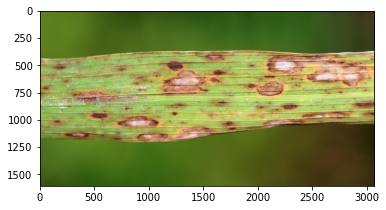

1
(28422, 128)
(200,)
[177 460  57 287   2  80 419  76  39 192 428  65 211  70  49 128 100  89
  87 281  78 155   5 396  75 240 243  45 109 191 150 253  40 131 281 136
 185 295 117  52  59   6 224  29 136  18  98 168 246 166 209  25  89 212
  65  46  77  77 193  65 148  41 209 149  45 427 124 124  75 241 175  83
 141 124 229 123  54 158  35  11 157  72  62 104 270 254  31  51 174 339
 145  55 210 245 305  62 135 172 200  52  49 244 145 156 270   0 112  77
  38  71 106  87 155 107 156  74 149 247 201 182  76 200  56  22  60 113
 104 149  67  72 119  27 245  96 207 103 125  53  56 128 158  15 129 125
 196  53  69  40 134 280 118 182 237  84  74 323  73 111  51  95 139 142
 136 160  54 124 151 106 116  75 417 134 174   8 269  44 329 220 149 133
 248 238 120 204 273  45 177  50 369  94  65 102 324 200 340 151 138 148
 187 125]
/content/drive/MyDrive/external_images/bs2.jpg
[2]
Loại bệnh: Brown spot
------------------------------------------


In [ ]:
import glob
img = None
folder = glob.glob('/content/drive/MyDrive/external_images/*.*')
for file in folder:
  img = cv2.imread(file)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  my_X = [img]
  my_image_descriptors = None
  my_X_features = None
  my_image_descriptors = extract_sift_features(my_X)
  my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
  print(len(my_image_descriptors))
  print(my_image_descriptors[0].shape)
  print(my_X_features[0].shape)
  print(my_X_features[0])
  y_pred = None
  y_pred = svm.predict(my_X_features)
  print(file)
  print(y_pred)
  print('Loại bệnh: ' + classes[y_pred[0]])
  print('------------------------------------------')